In [1055]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()


Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=-1295454813 seed_offset=0 real_seed=-1295454813
core.init.random: RandomGenerat

In [1056]:
import math
import random
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from pyrosetta.rosetta.protocols.moves import *
from pyrosetta.rosetta.core.id import *
from recces.data import *
from recces.util import *
from rosetta.protocols.rna import *

In [1057]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [1058]:
def initialize_pose(seq1, seq2):
    
    n_residues = len(seq1) + len(seq2)
    
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq1, seq2)
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
    
        if seq2 and ii == (n_residues/2) - 1: continue
            
        dof_dict.update({6*ii:TorsionID(ii+2, BB, 1), 6*ii+1:TorsionID(ii+2, BB, 2), 6*ii+2:TorsionID(ii+2, BB, 3),
                 6*ii+3:TorsionID(ii+1, BB, 5), 6*ii+4:TorsionID(ii+1, BB, 6)})

        movemap.set(TorsionID(ii+2, BB, 1), True)
        movemap.set(TorsionID(ii+2, BB, 2), True)
        movemap.set(TorsionID(ii+2, BB, 3), True)
        movemap.set(TorsionID(ii+1, BB, 5), True)
        movemap.set(TorsionID(ii+1, BB, 6), True)
        
    for ii in range(n_residues-1):
        
        dof_dict.update({6*ii+5:TorsionID(ii+1, CHI, 1)})
        
    dof_dict.update({6*(n_residues-1):TorsionID(n_residues, CHI, 1)})
    
    movemap.set_chi(True)
        
        
        
    return pose, movemap, dof_dict

In [1059]:
def find_minimum(pose, sf, movemap):
    
    
    minimum = Pose()
    minimum.assign(pose)
    
    n_residues = pose.total_residue()
    
    movemap = MoveMap()
    for ii in range(n_residues-1):
        
        minimum.set_alpha(  ii+2, random.uniform(0, 360))
        minimum.set_beta(   ii+2, random.uniform(0, 360))
        minimum.set_gamma(  ii+2, random.uniform(0, 360))
        minimum.set_epsilon(ii+1, random.uniform(0, 360))
        minimum.set_zeta(   ii+1, random.uniform(0, 360))
             
    for ii in range(n_residues):
        
        pose.set_chi(ii+1, random.uniform(0, 360))

    
    minmover = rosetta.protocols.minimization_packing.MinMover(movemap, sf, 'linmin_iterated', 1e-6, True)
    minmover.max_iter(100000)
    minmover.apply(minimum)
    
    return minimum   

In [614]:
def helix_state(pose, dof_dict):
    
    n_residues = pose.total_residue()
    
    # Definition of helix state backbone torsions
    for ii in range(n_residues - 1):
        
        if ii == n_residues/2 - 1: continue
        
        pose.set_torsion(dof_dict[6*ii], -64.11)
        pose.set_torsion(dof_dict[6*ii+1], 176.33)
        pose.set_torsion(dof_dict[6*ii+2], 53.08)
        pose.set_torsion(dof_dict[6*ii+3], -150.17)
        pose.set_torsion(dof_dict[6*ii+4], -71.45)   
       
    # Definition of helix state chi torsions
    for ii in range(n_residues-1): pose.set_torsion(dof_dict[6*ii+5], 79.43)
    
    return pose

In [615]:
def mode_scan(pose, dofs, dof_dict, scorefxn, mode, kT = 1.0, h = 0.5):
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(pose)
    E = E_0
    inc = 0
    result = 0.0
    
    max_inc = int(60/h)

    while inc < max_inc:
        
        inc += 1
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + (60.0)*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):

            if key > len(dofs)/2 -2: key += 5
            temp.set_torsion(dof_dict[key], val)
        
        E = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)

    # Reinitialize pose
    temp.assign(pose)
    inc = 0
    E = E_0
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + 60.0*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):
            
            if key > len(dofs)/2 - 2: key += 5 
            temp.set_torsion(dof_dict[key], val)
        E  = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)
        
    result *= h*np.pi/180.0
    return result

In [888]:
seq1 = 'ggg'
seq2 = 'ccc'

# Specify local path to where RECCES results are stored
try: 
    hist = SingleHistSimulation('./../recces_rosetta/results/'+seq1+'_'+seq2+'/ST/')
    norm = np.sum(hist._dos)
    print hist.value - np.log(torsion_volume(seq1, seq2))
except ValueError: pass

n_residues = len(seq1) + len(seq2)

pose, movemap, dof_dict = initialize_pose(seq1, seq2)
#pose = pose_from_pdb('aaa_uuu_chainbreak.pdb')
scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('/stepwise/rna/turner')
scorefxn = rna_hires
#scorefxn.set_weight(core.scoring.lk_nonpolar, 0)
#scorefxn.set_weight(core.scoring.stack_elec, 0)


-24.0789947859


In [889]:
minmover = rosetta.protocols.minimization_packing.MinMover(movemap, scorefxn, 'dfpmin', 1e-6, False)
minmover.max_iter(1000000)
minmover.min_options().use_nblist(True)
minmover.min_options().nblist_auto_update(True)
#pyrosetta.rosetta.protocols.rna.denovo.setup_coarse_chainbreak_constraints(pose, 2)

In [890]:
import itertools

minimum = Pose()

pose.assign(helix_state(pose, dof_dict))
minmover.apply(pose)
minimum.assign(pose)
print scorefxn.show(pose)
h = 0.25
h_rad = h*np.pi/180
E_0 = scorefxn(pose)

dofs = []

for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
dofs = np.array(dofs)

hessian = np.zeros((len(dofs), len(dofs)))

n_pts = int(2/h + 1)
ind = int(n_pts/2)

tor_ranges = np.zeros((n_pts, len(dofs)))
energy = np.zeros((n_pts, n_pts))

for ii, dof in enumerate(dofs):
            
    tor_ranges[:, ii] = dof + np.arange(-1, 1+h, h)
    
for pair in list(itertools.combinations(dof_dict.keys(), 2)):
    
    foo = pair[0]
    bar = pair[1]
    if foo > len(dofs)/2 - 2: foo -= 5
    if bar > len(dofs)/2 - 2: bar -= 5
    
    x = tor_ranges[:, foo]
    y = tor_ranges[:, bar]

    for ii, xx in enumerate(x):
            
        pose.set_torsion(dof_dict[pair[0]], xx)
        
        for jj, yy in enumerate(y):
            
            pose.set_torsion(dof_dict[pair[1]], yy)
            
            energy[ii, jj] = scorefxn(pose)

            pose.set_torsion(dof_dict[pair[1]], dofs[bar])
            
        pose.set_torsion(dof_dict[pair[0]], dofs[foo])
        
    hess = numpy_hessian(energy, h_rad)
    
    d2E_dx2 =  hess[0,0,:,:]
    d2E_dy2 =  hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[foo, foo] == 0:
        
        hessian[foo, foo] = d2E_dx2[ind, ind]
        
    if hessian[bar, bar] == 0:
        
        hessian[bar, bar] = d2E_dy2[ind, ind]
        
    hessian[foo, bar] = d2E_dxdy[ind, ind]
    hessian[bar, foo] = d2E_dxdy[ind, ind]
    
pose.assign(minimum)
try: scorefxn.show(ST_min)
except NameError: pass


core.scoring: 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 fa_atr                       0.730     -57.931     -42.289
 fa_rep                       0.100      36.335       3.633
 fa_intra_rep                 0.007      35.058       0.249
 lk_nonpolar                  0.250      -6.703      -1.676
 fa_elec_rna_phos_phos        4.540      -0.282      -1.282
 rna_torsion                  4.260       0.397       1.693
 stack_elec                   1.540      -0.893      -1.375
 hbond_sc                     2.460     -13.192     -32.451
---------------------------------------------------
 Total weighted score:                      -73.498
None


In [891]:
import scipy
import scipy.linalg

w,v = scipy.linalg.eigh(hessian)
print w,

[  1.56008423e+00   3.13468877e+00   4.25294747e+00   5.12542644e+00
   1.00798959e+01   1.08735598e+01   1.13974672e+01   1.41842212e+01
   1.76521334e+01   2.36633269e+01   2.46620262e+01   3.67080272e+01
   5.00069244e+01   7.27153065e+01   9.72357399e+01   1.32428854e+02
   2.10254925e+02   3.41099920e+02   4.13649091e+02   1.14230216e+03
   1.22982459e+03   1.27611512e+03   2.55930317e+03   5.80892486e+03
   1.06518845e+04   1.79805037e+04]


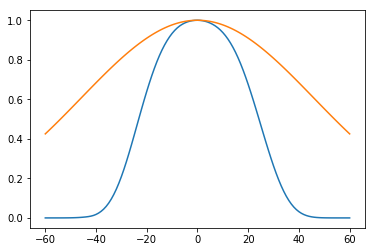

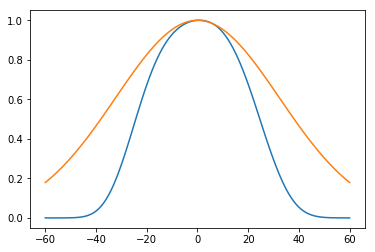

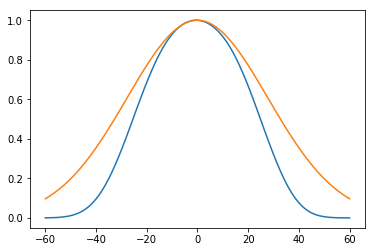

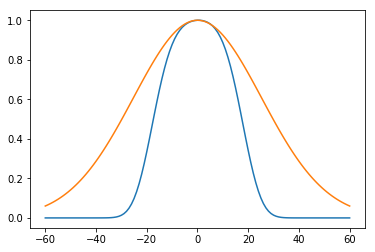

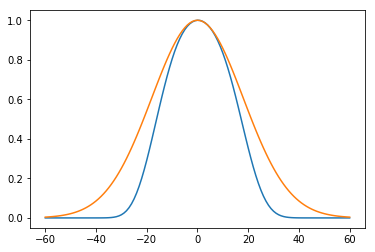

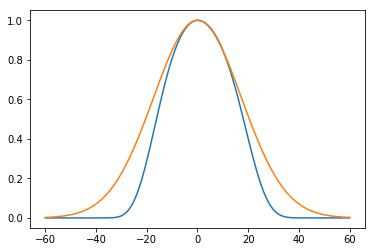

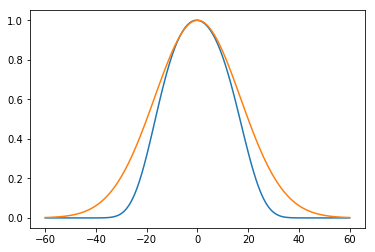

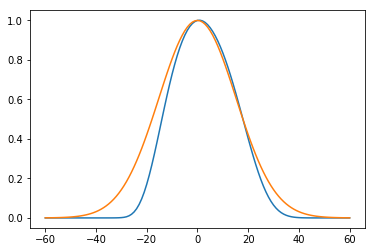

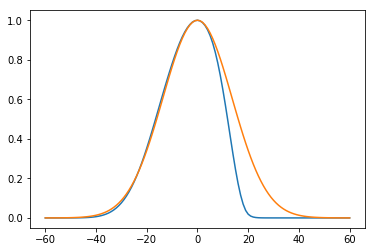

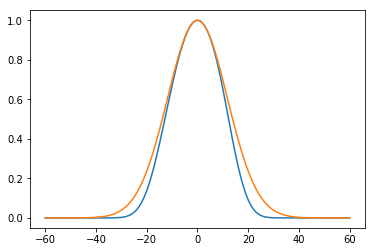

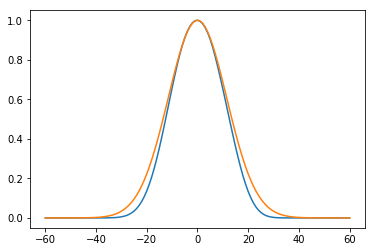

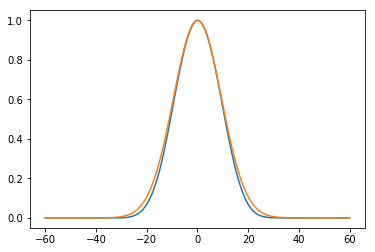

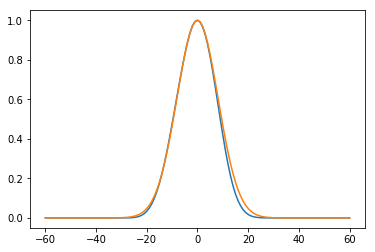

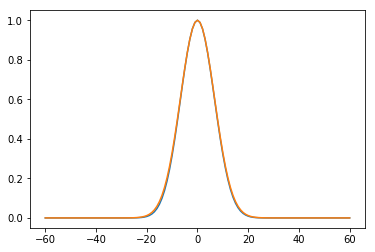

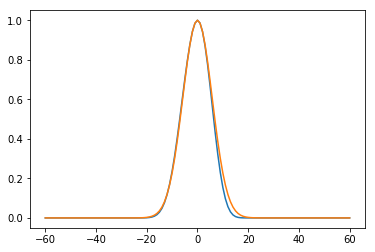

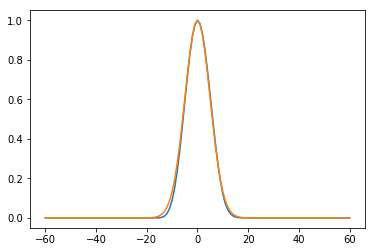

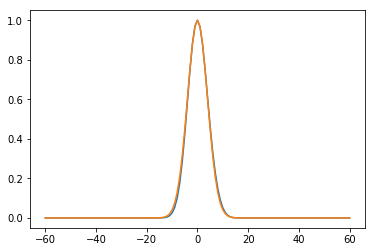

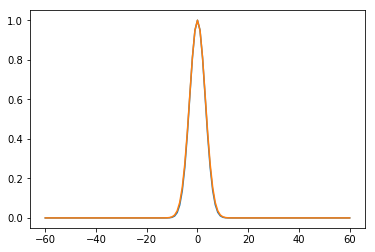

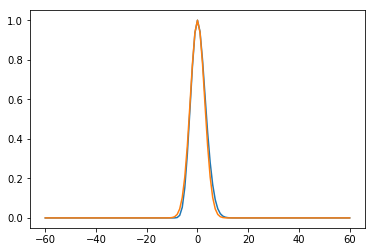

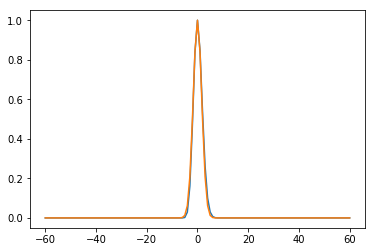

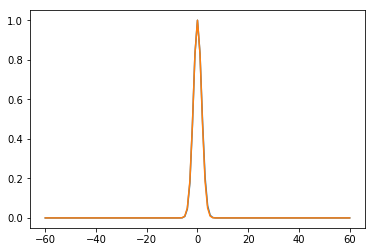

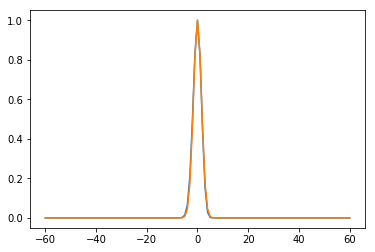

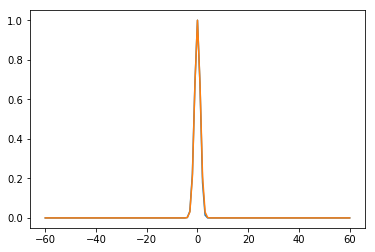

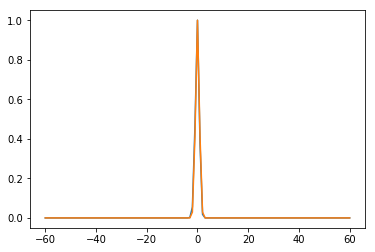

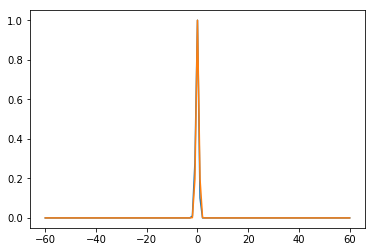

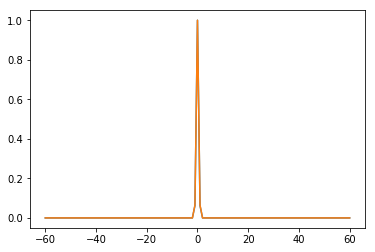

In [836]:
'''this code will assay the normal modes, plotting the corresponding boltzmann weights for both the harmonic approximation
and scanned modes'''

import scipy.integrate

pose.assign(minimum)
kT = 1.0

for kk, K in enumerate(w):
 
    mode = v[:,kk]
    h = np.arange(-60,61,1)
    h_plot = h*np.pi/180

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            if jj > len(dofs)/2 - 2: jj += 5
            pose.set_torsion(dof_dict[jj], dof)

        bar.append((scorefxn(pose)-E_0)/kT)

    np.array(bar) 
    pose.assign(minimum)
    plt.figure()
    #plt.subplot(5, 3, kk+1)
    plt.plot(h, np.exp(-np.array(bar)))
   
    plt.plot(h, np.exp(-0.5*K*h_plot**2/kT))
    #plt.xlabel('Displacement along normal coordinate (degrees)')
    #plt.ylabel('exp(-(E-E0)/kT)')

In [853]:
'''this code will calculate the configuration integral using both harmonic approximation and mode scanning'''

from scipy.special import *
pose.assign(minimum)
V = 1
kT = 1.0
Z_harm = 1.00
Z_scan = 1.00
for ii, K in enumerate(w):

    # Mode scanning
    Z_j = mode_scan(pose, dofs, dof_dict, scorefxn, v[:,ii], kT, h = 1)
    
    sig = min(2*np.pi/3, 6*np.sqrt(kT/K))
    V*=sig
    # Harmonic approximation
    Z_i = np.sqrt(2.0*np.pi*kT/K)*erf(np.sqrt(2.0*K/kT)*sig/4.0)
    
    Z_harm *= Z_i
    Z_scan *= Z_j
    
    pose.assign(minimum)
    
    print Z_i, Z_j

1.32771505776 0.912111623529
1.054266338 0.739882168457
0.77085216159 0.6287431536
0.718680175027 0.51508392968
0.657215156896 0.703940306062
0.540634945247 0.427478177498
0.513128890555 0.453084648946
0.339257847806 0.294379840351
0.188110827297 0.175647798702
0.159257045971 0.143163735084
0.0957650462818 0.105421803507
0.0623308564497 0.0617732940412
0.0413656622362 0.0396142804183
0.0351954669071 0.0328750458549


In [854]:
print -np.log(Z_harm) + scorefxn(minimum),  -np.log(Z_scan) + scorefxn(minimum)

-24.4025055938 -22.5041272823


In [841]:
def partition_function(kT):
    
    Z = 1
    for K in w:
        
        
        sig = np.pi/6
        Z *= math.sqrt(2.0*np.pi/K/kT)*erf(math.sqrt(2.0*kT*K)*sig/4.0)
        
    return Z/((2*np.pi/3)**len(w))

In [790]:
'this code defines an implementation of the Stehfest method for numerically calculating the inverse laplace transform'
import scipy.misc

fact = scipy.misc.factorial

def csteh(n, i):
    acc = 0.0
    for k in xrange(int(np.floor((i+1)/2.0)), int(min(i, n/2.0))+1):
        num = k**(n/2.0) * fact(2 * k)
        den = fact(i - k) * fact(k -1) * fact(k) * fact(2*k - i) * fact(n/2.0 - k)
        acc += (num /den)
    expo = i+n/2.0
    term = np.power(-1+0.0j,expo)
    res = term * acc
    return res.real

def nlinvsteh(t, F=partition_function, n = 18):
    acc = 0.0
    lton2 = np.log(2) / t
    for i in xrange(1, n+1):
        a = csteh(n, i)
        b = F(i * lton2)
        acc += (a * b)
        
    if lton2 * acc > 0.: return lton2 * acc
    else: return 0.

In [791]:
t = np.linspace(0,800,8001)
A = []
for tt in t: A.append(nlinvsteh(tt))
t = np.array(t)
A = np.array(A)
A[A<0.]=0.0


/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [629]:
plt.plot(t[:600]+rna_hires(minimum), 0.15*A[:600]*torsion_volume(seq1, seq2)*np.exp(-t[:600]/1.0)*(np.pi/6)**len(w)*2e14)
#plt.plot(r+E_avg, 0.1*np.exp(g)*np.exp(-r))
plt.plot(hist._dos_scores[201:800], hist._dos[201:800]*np.exp(-hist._dos_scores[201:800]/1.0))
plt.plot(t[:600]+rna_hires(minimum), 0.105*matt_guess(E[1000:1600])*np.exp(-(E[1000:1600])/1.0)*(2*np.pi)**len(w))
plt.xlabel('Energy (RU)')
plt.ylabel('g(E)')
plt.legend(('Mining Minima', 'RECCES', 'Analytical'))

TypeError: can't multiply sequence by non-int of type 'float'

In [792]:
bar = scipy.special.logsumexp(-(t+rna_hires(minimum)), b = A)
print bar
print scipy.special.logsumexp(-hist._dos_scores, b = hist._dos)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [793]:
plt.plot(t[:1000]+rna_hires(minimum),np.exp(-(t[:1000]+scorefxn(minimum))/1.0)*A[:1000]/np.exp(-scorefxn(minimum))*4e14)
plt.plot(hist._dos_scores[260:1200],hist._dos[260:1200]*np.exp(-(hist._dos_scores[260:1200]/1.0)))

ValueError: operands could not be broadcast together with shapes (1000,) (727,) 

In [794]:

print t[100:] + scorefxn(minimum)

[ -32.60103451  -32.50103451  -32.40103451 ...,  757.19896549  757.29896549
  757.39896549]


In [795]:
from recces.util import *
from recces.data import *
curr_wt = [0.73, 0.1, 0.0071, 0, 4.26, 2.46, 0.25, 0, 1.54, 4.54]

In [796]:
E = np.linspace(-100,800,9001)
print t

[  0.00000000e+00   1.00000000e-01   2.00000000e-01 ...,   7.99800000e+02
   7.99900000e+02   8.00000000e+02]


In [1251]:




E_avg = rna_hires(minimum)
print E_avg

-42.6010345083


In [893]:
matt_guess = lambda E: 2*(2*np.pi)**((len(w)-1)/2)*(2*(E))**(len(w)/2-1)/scipy.misc.factorial2(len(w)-2)/np.sqrt(np.linalg.det(hessian))

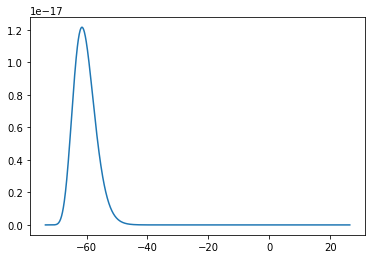

In [894]:
#plt.plot(t[:1000]+rna_hires(minimum),np.exp(-(t[:1000])/1.0)*A[:1000]*1e12)# numerical 
#plt.plot(t[:1000]+E_avg, harmonic_dos(t[:1000])*np.exp(-((t[:1000])/1.00))/torsion_volume(seq1,seq2)*5e17)# harmonic
#plt.plot(hist._dos_scores[260:1200], hist._dos[260:1200]*np.exp(-hist._dos_scores[260:1200]/1.0)) # RECCES
norm = np.sum(hist._dos)*torsion_volume(seq1, seq2)
a = 0.0001/scipy.integrate.trapz(matt_guess(E))
plt.plot(E[1000:2000]+E_avg, matt_guess(E[1000:2000])*np.exp(-(E[1000:2000])/1.0))# Matt's guess for analytical

In [895]:
print np.sum(matt_guess(E))
print np.sum(hist._dos)

9.40059101822e+12
0.000102117613845


In [862]:
print hist._dos_scores
dos_scores = np.array(hist._dos_scores)
dos = np.array(hist._dos)
print -scipy.misc.logsumexp(-dos_scores,b=dos) - np.log(torsion_volume(seq1, seq2))
print hist.value - np.log(torsion_volume(seq1,seq2)), 

[-100.   -99.9  -99.8 ...,  799.8  799.9  800. ]
-12.9781145115
-12.9781145115


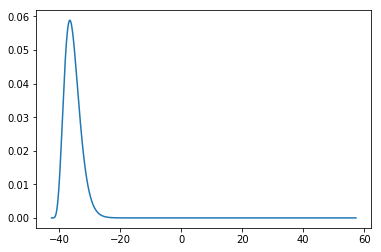

In [863]:
plt.plot(t[:1000]+E_avg, matt_guess(t[:1000])*np.exp(-(t[:1000])/1.0))

In [864]:
bar = -scipy.special.logsumexp(-(E[1000:2000]), b=matt_guess(E[1000:2000])) - np.log(torsion_volume(seq1, seq2))
print bar
print hist.value - np.log(torsion_volume(seq1, seq2))

-11.648696623
-12.9781145115


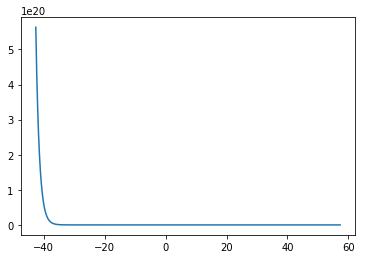

In [865]:
plt.plot(t[:1000]+scorefxn(minimum), harmonic_dos(t[:1000]-E_avg)*np.exp(-(t[:1000]+scorefxn(minimum))))

In [866]:
print bar - np.log(torsion_volume(seq1, seq2))
print hist.value - np.log(torsion_volume(seq1, seq2))

-21.9984035113
-12.9781145115


In [388]:
print pose.annotated_sequence()

a[RAD:LowerRNA:Virtual_Phosphate]aau[URA:Virtual_Phosphate]uu[URA:UpperRNA]


In [389]:
pyrosetta.rosetta.protocols.rna.denovo.setup_coarse_chainbreak_constraints(pose, 2)

In [393]:
print pose.annotated_sequence()
print minimum.fold_tree()

a[RAD:LowerRNA:Virtual_Phosphate]aau[URA:Virtual_Phosphate]uu[URA:UpperRNA]
FOLD_TREE  EDGE 1 6 -1 


In [8]:
rna_hires = protocols.rna.denovo.get_rna_hires_scorefxn()
print scorefxn, rna_hires

core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
basic.io.database: Database file opened: scoring/score_functions/carbon_hbond/ch_o_bond_potential.dat


NameError: name 'scorefxn' is not defined

In [14]:
print rna_hires
rna_hires.set_weight(core.scoring.ch_bond, 0.)
rna_hires.set_weight(core.scoring.rna_sugar_close, 0.)
rna_hires.set_weight(core.scoring.hbond_lr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sc, 0.)
rna_hires.set_weight(core.scoring.geom_sol, 0.)
rna_hires.set_weight(core.scoring.atom_pair_constraint, 0.)
rna_hires.set_weight(core.scoring.fa_atr,0.73)
rna_hires.set_weight(core.scoring.fa_rep, 0.10)
rna_hires.set_weight(core.scoring.fa_intra_rep, 0.0071) 
rna_hires.set_weight(core.scoring.lk_nonpolar, 0.25) 
rna_hires.set_weight(core.scoring.fa_elec_rna_phos_phos, 4.54) 
rna_hires.set_weight(core.scoring.rna_torsion, 4.26) 
rna_hires.set_weight(core.scoring.stack_elec, 1.54) 
rna_hires.set_weight(core.scoring.hbond_sc, 2.46)
print scorefxn

ScoreFunction::show():
weights: (fa_atr 0.23) (fa_rep 0.12) (fa_intra_rep 0.0029) (lk_nonpolar 0.32) (fa_elec_rna_phos_phos 1.05) (ch_bond 0.42) (rna_torsion 0.1) (rna_sugar_close 0.7) (hbond_sr_bb_sc 0.62) (hbond_lr_bb_sc 3.4) (hbond_sc 3.4) (geom_sol 0.62) (atom_pair_constraint 1)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files: 
EnergyMethodOptions::show: netcharge_setup_files: 
EnergyMethodOptions::show: aspartimide_penalty_value: 25
EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
EnergyMethodOptions::show: exclude_RNA_RN

In [11]:
def wang_landau(K):
    '''Computes the density of states using the Wang-Landau algorithm (see, e.g., )'''
    
    #E = lambda x: 0.5*np.dot(K, x**2)
    
    E = mm_energy(pose, )
    dr = 0.005
    f = np.exp(1)
    r = np.arange(0,50,dr)
    g = np.zeros_like(r)
    H = np.zeros_like(r)
    x_0 = 0.05*np.ones_like(K)
    print E(x_0)
    
    while f > np.exp(1e-8):
    
        ii = 0
        print f
        while ii < 100000:

            x = np.random.uniform(0, 0.08, (len(K)))
            x_ind = int(E(x)/dr)
            x_0_ind = int(E(x_0)/dr)
            if x_ind > H.shape[0]-1: continue

            if np.log(g[x_ind]) < np.log(g[x_0_ind]) or np.exp(np.log(g[x_ind])-np.log(g[x_0_ind])) < np.random.uniform():


                H[x_ind] += 1
                g[x_ind] += f
                x_0 = x

            else: 

                H[x_0_ind] += 1
                g[x_0_ind] += f
                
            ii += 1

        if H.any < 0.95*np.average(H): continue 

        f = f**0.5
        H = np.zeros_like(r)

    return g, r

In [885]:
g, r = wang_landau(w)
g = g/max(g)

NameError: name 'wang_landau' is not defined

In [82]:
plt.plot(r, np.exp(g)*np.exp(-r))
print -np.log(scipy.special.logsumexp(-(r+scorefxn(minimum)), b=g)) - np.log(torsion_volume(seq1, seq2))

NameError: name 'r' is not defined

In [83]:
plt.plot(r, np.exp(g))

NameError: name 'r' is not defined

In [1344]:
def mm_energy(pose, delta, dof_dict, sf):
    
    temp = Pose()
    temp.assign(pose)
            
    for key, val in enumerate(delta):

        if key > len(dofs)/2 -2: key += 5
        temp.set_torsion(dof_dict[key], pose.torsion(dof_dict[key]) + 0.5*(val*180./np.pi)**2)
        
    return sf(temp)

In [897]:
norm = np.sum(hist._dos)

In [900]:
print np.log(norm*torsion_volume(seq1, seq2))

10.0314988892


In [896]:
max(matt_guess(E[1000:2000])*np.exp(-E[1000:2000]))

1.2167939471894875e-17

In [ ]:
dr = 1
r = np.arange(0,800,dr)
g = np.zeros_like(r)
H = np.zeros_like(r)

f = np.exp(1)
sig = 1/np.sqrt(w)

delta_0 = np.zeros_like(w)
E_min = scorefxn(minimum)
E_0 = E_min

while np.log(f) > 1e-8:

    print f
    H[:] = 0
    
    for i in range(100000):

        delta = np.random.uniform(-2*np.pi/3, 2*np.pi/3, (len(w)))
        sig = 1/np.sqrt(w[np.random.randint(0,len(w))])
        delta *= 1

        #y = np.random.randint(0,len(w))
        #delta = v[:,y]*np.random.uniform(-np.pi/3,np.pi/3)
        
        
        E = mm_energy(minimum, delta, dof_dict, scorefxn)
        
        ind = int((E-E_min)/dr)
        ind_0 = int((E_0-E_min)/dr)

        if ind > len(r) -1: continue
        if ind_0 > len(r) -1: ind_0 = -1
        if g[ind] < g[ind_0] or np.exp(-g[ind]+g[ind_0]) < np.random.uniform():

            if ind > len(r) - 1: ind = -1
            g[ind] += np.log(f)
            H[ind] += 1
            delta_0 = delta
            E_0 = E
            
        else:

            g[ind_0] += np.log(f)
            H[ind_0] += 1
            
    f = np.sqrt(f)




2.71828182846
1.6487212707
1.28402541669
1.13314845307
1.06449445892
1.0317434075
1.01574770859


-10.3497068884


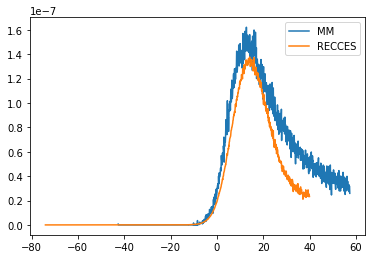

In [1394]:
0
plt.plot(r[:1000]+E_avg, g[:1000]/50000/torsion_volume(seq1, seq2))
print -scipy.special.logsumexp(-r, b=g) - np.log(torsion_volume(seq1, seq2))
plt.plot(hist._dos_scores[260:1400], hist._dos[260:1400])
plt.legend(('MM', 'RECCES'))

In [1329]:
print scorefxn(minimum)

-42.6010345083


In [1330]:
print scorefxn(minimum) / 0.1

-426.010345083


In [1349]:
print g


[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

In [1298]:
np.set_printoptions(threshold='nan')